In [1]:
!pip install -U setuptools numba

In [2]:
import triton

In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
)
import transformers

from datasets import load_dataset
from composer import Trainer    
from composer.models import HuggingFaceModel, ComposerModel

import torch
from torch.utils.data import DataLoader

from ModernBERT.src.sequence_packer import GreedyBestFitSequencePacker

from tqdm import tqdm

model_name = "roneneldan/TinyStories-1M"
config = AutoConfig.from_pretrained(model_name)
config.max_position_embeddings = 1024
model = AutoModelForCausalLM.from_config(config, attn_implementation='flash_attention_2').to('cuda')
sum(p.numel() for p in model.parameters() if p.requires_grad)

/usr/lib/python3/dist-packages/flash_attn/ops/triton/layer_norm.py:984: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/lib/python3/dist-packages/flash_attn/ops/triton/layer_norm.py:1043: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`


3680448

In [4]:
max_vocab_size = 2048

In [5]:
train_data = load_dataset('roneneldan/TinyStories', split='train')
val_data = load_dataset('roneneldan/TinyStories', split='validation').with_format('np')

In [6]:
def remove_rows_with_keyword(dataset, keyword):
    """
    Remove rows from a dataset where the 'text' field contains the specified keyword.
    
    Args:
        dataset: A Hugging Face dataset
        keyword: String to search for in the text
        
    Returns:
        Filtered dataset without rows containing the keyword
    """
    filtered_indices = [i for i, example in enumerate(dataset) if keyword not in example['text']]
    return dataset.select(filtered_indices)

# Example usage:
keywords_to_filter = ["drown", "violent", "died", "kill", "bad ending", ]
filtered_train_data = train_data
for keyword in keywords_to_filter:
    # filtered_train_data = remove_rows_with_keyword(filtered_train_data, keyword)
    pass
    
print(f"Original dataset size: {len(train_data)}, Filtered dataset size: {len(filtered_train_data)}")

Original dataset size: 2119719, Filtered dataset size: 2119719


In [7]:
def get_training_corpus():
    for start_idx in range(0, len(train_data), 10000):
        patch = train_data[start_idx: start_idx+10000]
        yield patch['text']
        

In [8]:
corpus = get_training_corpus()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
# tokenizer = tokenizer.train_new_from_iterator(corpus, vocab_size=max_vocab_size)
# tokenizer.save_pretrained(f'./training/tokenizer/{max_vocab_size}')

In [10]:
tokenizer = tokenizer.from_pretrained(f'./training/tokenizer/{max_vocab_size}')

In [11]:
model.resize_token_embeddings(tokenizer.vocab_size)

Embedding(2048, 64)

In [12]:
for n, i in sorted([(k, v) for v, k in tokenizer.vocab.items()]):
    print(n, i)

0 <|endoftext|>
1 !
2 "
3 #
4 $
5 %
6 &
7 '
8 (
9 )
10 *
11 +
12 ,
13 -
14 .
15 /
16 0
17 1
18 2
19 3
20 4
21 5
22 6
23 7
24 8
25 9
26 :
27 ;
28 <
29 =
30 >
31 ?
32 @
33 A
34 B
35 C
36 D
37 E
38 F
39 G
40 H
41 I
42 J
43 K
44 L
45 M
46 N
47 O
48 P
49 Q
50 R
51 S
52 T
53 U
54 V
55 W
56 X
57 Y
58 Z
59 [
60 \
61 ]
62 ^
63 _
64 `
65 a
66 b
67 c
68 d
69 e
70 f
71 g
72 h
73 i
74 j
75 k
76 l
77 m
78 n
79 o
80 p
81 q
82 r
83 s
84 t
85 u
86 v
87 w
88 x
89 y
90 z
91 {
92 |
93 }
94 ~
95 ¡
96 ¢
97 £
98 ¤
99 ¥
100 ¦
101 §
102 ¨
103 ©
104 ª
105 «
106 ¬
107 ®
108 ¯
109 °
110 ±
111 ²
112 ³
113 ´
114 µ
115 ¶
116 ·
117 ¸
118 ¹
119 º
120 »
121 ¼
122 ½
123 ¾
124 ¿
125 À
126 Á
127 Â
128 Ã
129 Ä
130 Å
131 Æ
132 Ç
133 È
134 É
135 Ê
136 Ë
137 Ì
138 Í
139 Î
140 Ï
141 Ð
142 Ñ
143 Ò
144 Ó
145 Ô
146 Õ
147 Ö
148 ×
149 Ø
150 Ù
151 Ú
152 Û
153 Ü
154 Ý
155 Þ
156 ß
157 à
158 á
159 â
160 ã
161 ä
162 å
163 æ
164 ç
165 è
166 é
167 ê
168 ë
169 ì
170 í
171 î
172 ï
173 ð
174 ñ
175 ò
176 ó
177 ô
178 õ
179 ö
180 ÷
181 ø
182 ù


In [13]:
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): GPTNeoForCausalLM(
    (transformer): GPTNeoModel(
      (wte): Embedding(2048, 64)
      (wpe): Embedding(1024, 64)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPTNeoBlock(
          (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): GPTNeoAttention(
            (attention): GPTNeoFlashAttention2(
              (attn_dropout): Dropout(p=0.0, inplace=False)
              (resid_dropout): Dropout(p=0.0, inplace=False)
              (k_proj): Linear(in_features=64, out_features=64, bias=False)
              (v_proj): Linear(in_features=64, out_features=64, bias=False)
              (q_proj): Linear(in_features=64, out_features=64, bias=False)
              (out_proj): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mlp): GPTNeoMLP(
            (c_fc): Linear(in_features=64, out_

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad) - model.lm_head.weight.numel()

464000

In [15]:
def tokenize(e):
    out = tokenizer(e['text'], truncation=True, return_attention_mask=False)
    out['input_ids'].append(tokenizer.eos_token_id)
    return out 
tokenizer.pad_token = tokenizer.eos_token
# tok_train = train_data.map(tokenize, remove_columns=['text'], num_proc=8)
# tok_val  = val_data.select(range(1000)).map(tokenize, remove_columns=['text'], num_proc=8)

# tok_train = filtered_train_data.map(tokenize, remove_columns=['text'], num_proc=8)
# tok_val  = val_data.select(range(1000)).map(tokenize, remove_columns=['text'], num_proc=8)

In [16]:
class SeqPackIter:
    def __init__(self, ds):
        self.ds = [[i] for i in tqdm(ds)]
        
    def __iter__(self):
        return iter(self.ds)
    
    def __len__(self):
        return len(self.ds)

In [17]:
# seq_iter = SeqPackIter(tok_train)

In [18]:
# iter_obj = iter(seq_iter)

In [19]:
# sequence_packer = GreedyBestFitSequencePacker.from_composer(
#     src_iterable = seq_iter,
#     micro_batch_size=1,
#     batch_size=1,
#     max_seq_len=1024,
#     pad_token_id=0,
#     mask_token_id=0,
#     ignore_token_id=0,
#     mask_prob=0.0,
# )

In [20]:
# iter_seq_pack = iter(sequence_packer)

In [21]:
# next(iter_seq_pack)['input_ids'].shape

In [22]:
# import matplotlib.pyplot as plt
# # Reset the iterator
# iter_seq_pack = iter(sequence_packer)

# # Collect context lengths
# context_lengths = [len(i['input_ids']) for i in tqdm(tok_train)]
# # context_lengths = []
# plt.show()
# plt.figure(figsize=(10, 6))
# plt.hist(context_lengths, bins=50)
# plt.title('Distribution of Context Lengths')
# plt.xlabel('Context Length')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()



In [23]:
max_len = 10
max_pos = []
max_token = []
for k, v in tokenizer.vocab.items():
    if len(k) > max_len:
        max_pos.append(v)
        max_token.append(k)

max_token, max_len, max_pos

(['Ġadventures',
  'Ġeverything',
  'Ġremembered',
  'Ġeverywhere',
  'Ġunderstand',
  '<|endoftext|>'],
 10,
 [1906, 1601, 1405, 1757, 1454, 0])

In [24]:
# !rm -rf ./datasets/tinystories/packed/2048

In [25]:
from streaming import MDSWriter
import numpy as np
from tqdm import tqdm

out_root = f'./datasets/tinystories/packed/{tokenizer.vocab_size}/'
out_train = out_root + 'train/'
out_val = out_root + 'val/'

columns = {
    'input_ids': 'ndarray:int32',
    # 'attention_mask': 'ndarray:int64',
}
# with MDSWriter(out=out_train, columns=columns, compression='zstd') as writer:
#     for sample in tqdm(sequence_packer):
#         sample['input_ids'] = sample['input_ids'].squeeze().numpy().astype(np.int32)
#         writer.write(sample)
        
# print('done with train')
# with MDSWriter(out=out_val, columns=columns, compression='zstd') as writer:
#     for sample in tok_val:
#         sample['input_ids'] = sample['input_ids'].astype(np.int32)
#         writer.write(sample)
        

In [26]:
from streaming import StreamingDataset
bs = 64
tok_train = StreamingDataset(local=out_train, shuffle=True, shuffle_seed=42, batch_size=bs)
tok_val = StreamingDataset(local=out_val, batch_size=bs)

In [27]:
tok_train[0].keys()

dict_keys(['input_ids'])

In [28]:
len(tok_train)

564263

In [29]:
tok_train[0]['input_ids'].shape

(1024,)

In [30]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(e['input_ids']).to('cuda').to(torch.int64) for e in batch])
    # masks = torch.stack([torch.tensor(e['attention_mask']).to('cuda') for e in batch])
    labels = torch.stack([torch.tensor(e['input_ids']).to('cuda').to(torch.int64) for e in batch])
    return {
        'input_ids': input_ids,
        # 'attention_mask': masks,
        'labels': labels,
        # 'inputs_embeds': None
    }

In [31]:
collator = collate_fn

torch.random.manual_seed(42)
dl_train = DataLoader(tok_train[:-bs*2], batch_size=bs, collate_fn=collate_fn)
dl_val = DataLoader(tok_train[-bs * 2:], batch_size=bs, shuffle=False, collate_fn=collate_fn)

In [32]:
len(dl_train), len(dl_val)

(8815, 2)

In [33]:
next(iter(dl_train))['input_ids'].shape

torch.Size([64, 1024])

In [34]:
class MyModel(HuggingFaceModel):
    def __init__(self, model, tokenizer, metrics=[], use_logits=False):
        super().__init__(model, tokenizer, metrics=metrics, use_logits=use_logits)
            

    def forward(self, batch):
        return self.model(**batch)
    
    def loss(self, outputs, batch):
        return outputs.loss

In [35]:
batch = next(iter(tok_train))

In [36]:
tokenizer.batch_decode(batch['input_ids'])

['Tom',
 ' and',
 ' Mia',
 ' like',
 ' to',
 ' play',
 ' on',
 ' the',
 ' beach',
 '.',
 ' They',
 ' like',
 ' to',
 ' build',
 ' sand',
 ' cast',
 'les',
 ' and',
 ' s',
 'ur',
 'f',
 ' on',
 ' the',
 ' wa',
 'ves',
 '.',
 ' They',
 ' have',
 ' a',
 ' big',
 ' bucket',
 ' and',
 ' a',
 ' small',
 ' sho',
 'vel',
 ' to',
 ' make',
 ' their',
 ' cast',
 'les',
 '.',
 ' They',
 ' have',
 ' a',
 ' blue',
 ' s',
 'ur',
 'f',
 ' bo',
 'ard',
 ' to',
 ' ride',
 ' on',
 ' the',
 ' water',
 '.',
 '\n',
 '\n',
 'One',
 ' day',
 ',',
 ' they',
 ' go',
 ' to',
 ' the',
 ' beach',
 ' with',
 ' their',
 ' mom',
 ' and',
 ' dad',
 '.',
 ' They',
 ' find',
 ' a',
 ' good',
 ' spot',
 ' to',
 ' build',
 ' their',
 ' sand',
 ' castle',
 '.',
 ' They',
 ' d',
 'ig',
 ' and',
 ' p',
 'ile',
 ' and',
 ' pat',
 ' the',
 ' sand',
 '.',
 ' They',
 ' make',
 ' a',
 ' big',
 ' tower',
 ' and',
 ' a',
 ' small',
 ' door',
 '.',
 ' They',
 ' put',
 ' she',
 'll',
 's',
 ' and',
 ' st',
 'on',
 'es',
 ' to',
 ' d

In [37]:
from torchmetrics.classification import MulticlassAccuracy
from composer.models.huggingface import HuggingFaceModel
from composer.metrics import CrossEntropy, MaskedAccuracy, LanguageCrossEntropy

metrics = [MaskedAccuracy(ignore_index=0), LanguageCrossEntropy(ignore_index=0)]
# Package as a trainer-friendly Composer model
my_model = MyModel(model, tokenizer, metrics=metrics, use_logits=True)

In [38]:
from composer import Evaluator
eval_evaluator = Evaluator(
    label='acc',
    dataloader=dl_val,
    metric_names=['LanguageCrossEntropy', 'MaskedAccuracy'],
    device_eval_microbatch_size='auto'
)

/usr/lib/python3/dist-packages/composer/core/evaluator.py:147: UserWarning: Setting `device_eval_microbatch_size='auto'` is an experimental feature which may cause uncaught Cuda Out of Memory errors. In this case, please manually set device_eval_microbatch_size explicitly to an integer instead.
  warnings.warn((


In [39]:
from composer.optim import DecoupledAdamW, CosineAnnealingWithWarmupScheduler
from composer.loggers import InMemoryLogger, FileLogger
from composer.metrics import MaskedAccuracy

optim = DecoupledAdamW(my_model.parameters(), lr=2e-3, weight_decay=1e-7)
lr_scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='100ba', t_max="1dur")

logger = InMemoryLogger()

trainer = Trainer(
    model=my_model,
    train_dataloader=dl_train, 
    eval_dataloader=eval_evaluator,
    optimizers=optim,
    schedulers=lr_scheduler,
    max_duration="2ep",
    eval_interval='1ba',
    save_folder="training/pretrain/33M/packed/" + str(optim.param_groups[0]['lr']),
    save_interval="2000ba",
    # save_filename="hf_model.pt",
    save_overwrite=True,
    device_train_microbatch_size='auto',
    loggers=logger,
    device='gpu',
    precision='amp_bf16',
)

/usr/lib/python3/dist-packages/composer/trainer/trainer.py:247: UserWarning: `device_train_microbatch_size='auto'` may potentially fail with unexpected CUDA errors. Auto microbatching attempts to catch CUDA Out of Memory errors and adjust the batch size, but it is possible CUDA will be put into an irrecoverable state due to PyTorch bugs, e.g. integer overflow. In this case, please manually set device_train_microbatch_size explicitly to an integer instead.
  warnings.warn((


In [40]:
import time
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
composer_commit_hash: None
composer_version: 0.30.0
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 1622799068

******************************


train          Epoch   0:    0%|| 0/8815 [00:00<?, ?ba/s]         

W0417 15:03:34.850000 5971 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


acc            Batch   1:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   2:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   3:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   4:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   5:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   6:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   7:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   8:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch   9:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  10:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  11:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  12:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  13:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  14:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  15:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  16:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  17:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  18:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  19:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  20:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  21:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  22:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  23:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  24:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  25:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  26:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  27:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  28:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  29:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  30:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  31:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  32:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  33:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  34:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  35:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  36:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  37:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  38:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  39:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  40:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  41:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  42:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  43:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  44:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  45:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  46:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  47:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  48:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  49:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  50:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  51:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  52:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  53:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  54:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  55:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  56:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  57:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  58:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  59:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  60:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  61:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  62:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  63:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  64:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  65:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  66:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  67:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  68:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  69:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  70:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  71:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  72:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  73:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  74:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  75:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  76:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  77:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  78:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  79:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  80:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  81:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  82:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  83:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  84:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  85:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  86:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  87:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  88:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  89:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  90:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  91:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  92:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  93:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  94:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  95:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  96:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  97:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  98:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch  99:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 100:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 101:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 102:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 103:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 104:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 105:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 106:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 107:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 108:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 109:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 110:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 111:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 112:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 113:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 114:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 115:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 116:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 117:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 118:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 119:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 120:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 121:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 122:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 123:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 124:    0%|| 0/2 [00:00<?, ?ba/s]         

acc            Batch 125:    0%|| 0/2 [00:00<?, ?ba/s]         

KeyboardInterrupt: 

In [41]:
logger.data.keys()

dict_keys(['time/epoch', 'time/batch', 'time/sample', 'time/batch_in_epoch', 'time/sample_in_epoch', 'time/token', 'time/token_in_epoch', 'trainer/device_train_microbatch_size', 'loss/train/total', 'metrics/train/MaskedAccuracy', 'metrics/train/LanguageCrossEntropy', 'trainer/acc/device_eval_microbatch_size', 'metrics/acc/MaskedAccuracy', 'metrics/acc/LanguageCrossEntropy'])

In [ ]:
def sample(model, tokenizer, prompt, max_length=50, device='cpu'):
    with torch.autocast('cuda', torch.bfloat16):
        input_ids = tokenizer(prompt, return_tensors='pt').to(device)
        model.eval()
        output = model.generate(**input_ids, max_length=max_length, do_sample=True, top_k=50, top_p=0.95, temperature=0.8)
        return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
print(sample(my_model, tokenizer, "Once upon a time", max_length=500, device='cuda:0'))

Once upon a time, there was a little girl named Lily. She loved to play outside in the sun. One day, she saw a little boy sitting on a bench. The boy was very sad and wanted to help her. 

Lily wanted to play with the boy and play with her. But the boy tried to catch the boy. She asked her, "Can I have a lab I?" The little boy said, "No, I want to play with you." 

Lily started to cry and said, "I just want to play with you. Can I play with me?" The boy replied, "Sure, I will catch you." The boy smiled and said, "That is my best thing to play with me."Once upon a time, there was a little boy named Timmy. Timmy loved to go outside in his room. One day, he was playing in the garden when he saw a big red stone in the air. It was a big box with long hair. Timmy was scared, but then he ran towards the box.

Timmy saw the stone on the box and said, "Let's go in and look for a pretty stone." Timmy's mommy said, "Okay, we can buy some stone."

After the bottraade, Timmy got some juice and a bi

In [ ]:
logger.data.keys()

dict_keys(['time/epoch', 'time/batch', 'time/sample', 'time/batch_in_epoch', 'time/sample_in_epoch', 'time/token', 'time/token_in_epoch', 'trainer/device_train_microbatch_size', 'loss/train/total', 'metrics/train/MaskedAccuracy', 'metrics/train/LanguageCrossEntropy'])

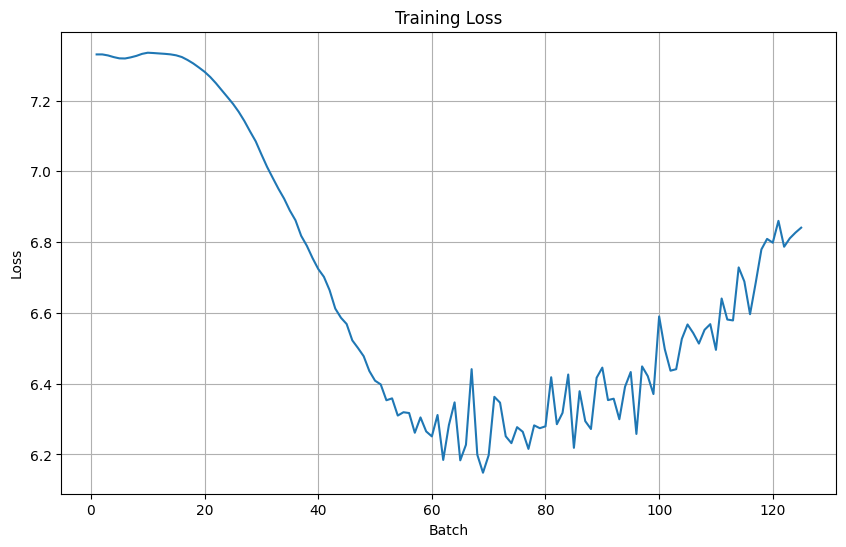

In [53]:
import matplotlib.pyplot as plt

# Extract time and loss values
time_values = []
loss_values = []
for t, v in logger.data['metrics/acc/LanguageCrossEntropy']:
    time_values.append(t.batch.value)
    loss_values.append(v.cpu().data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_values, loss_values)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)


In [ ]:
metrics[0].sum_loss

AttributeError: 'MaskedAccuracy' object has no attribute 'sum_loss'

In [ ]:
!ls training/pretrain/

In [ ]:
from composer.optim import DecoupledAdamW, CosineAnnealingWithWarmupScheduler
from composer.loggers import InMemoryLogger
from composer.metrics import MaskedAccuracy

optim = DecoupledAdamW(my_model.parameters(), lr=2e-4, weight_decay=0.0001)
lr_scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='200ba', t_max="1dur")

logger = InMemoryLogger()

trainer = Trainer(
    model=my_model,
    train_dataloader=dl_train, 
    eval_dataloader=eval_evaluator,
    optimizers=optim,
    schedulers=lr_scheduler,
    max_duration="2ep",
    eval_interval='1000ba',
    save_folder="training/pretrain/compile/" + str(optim.param_groups[0]['lr']),
    save_interval="5000ba",
    save_filename="hf_model.pt",
    save_overwrite=True,
    device_train_microbatch_size='auto',
    loggers=logger,
    device='gpu',
    precision='amp_bf16',
    autoresume=True,
)